In [1]:
import cu_rsc as cr
cr.setup_tables()
import RSC_sim
import numpy as np
import cupy as cp
import cupyx
import matplotlib.pyplot as plt
from tqdm import tqdm
M_dev = cr.load_m_table_device()        # upload to GPU
res   = cr.resources_from_config(M_dev)

c:\Users\LyuQi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### LZ with hot sample

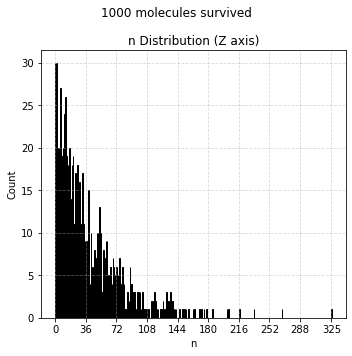

{'survival_rate_mean': array(1.),
 'survival_rate_sem': array(0.),
 'mot_mean': array([ 6.114,  7.842, 37.374]),
 'mot_sem': array([0.00639293, 0.00857224, 0.03788965]),
 'ground_state_rate_mean': array(0.),
 'ground_state_rate_sem': array(0.),
 'N': array(1000),
 'Ns_surv': array(1000),
 'B': array(1000)}

In [13]:
temp = [25e-6, 25e-6, 25e-6]
mol_0 = cr.build_thermal_molecules(1000, temp, detuning_sigma=0)
dist = cr.get_n_distribution_gpu(mol_0, max_bins=10, plot=(False, False, True))
result = cr.bootstrap_stats_from_molecules(mol_0)
result

In [14]:
print("survival rate: ", np.round(result["survival_rate_mean"], 3))
print("N_z bar: ", np.round(result["mot_mean"][2], 3))
print("Ground state rate: ", np.round(result["ground_state_rate_mean"],3))

survival rate:  1.0
N_z bar:  37.374
Ground state rate:  0.0


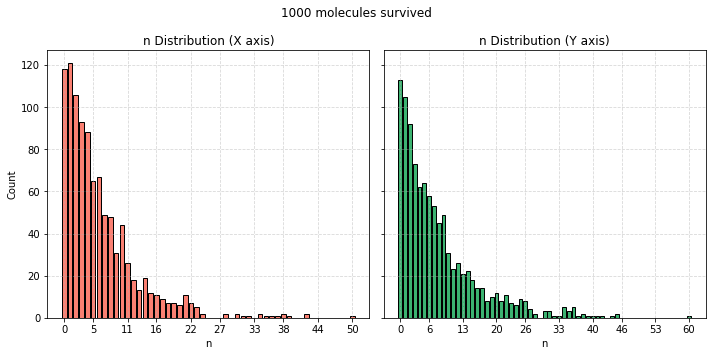

In [15]:
dist = cr.get_n_distribution_gpu(mol_0, max_bins=10, plot=(True, True, False))

In [16]:
zt_freqs = cp.linspace(-60e3, 60e3, 1000)
zt_rabi = 1.01e3
zt_pulse = 500e-6


frequencys, polarizations_opt = cr.raman_sideband_thermometry(
    molecules_dev=mol_0,
    axis=2,
    frequencys=zt_freqs,
    rabi_freq=zt_rabi,
    pulse_time=zt_pulse,
    res=res,
    k_max=2
)

Raman thermometry: 100%|██████████| 1000/1000 [00:17<00:00, 56.55it/s]


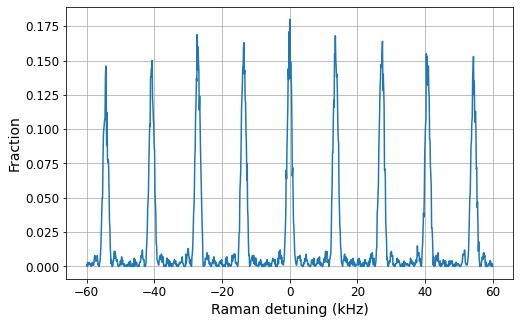

In [17]:
plt.figure(figsize=(8,5))
plt.plot(cp.asnumpy(frequencys*1e-3), cp.asnumpy(polarizations_opt)/1000)
plt.xlabel("Raman detuning (kHz)", fontsize=14)
plt.ylabel("Fraction", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid()

### LZ sweep

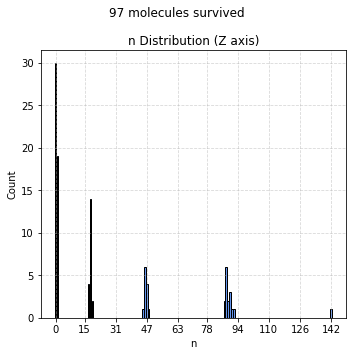

survival rate:  0.097
N_z bar:  24.835
Ground state rate:  0.0


In [18]:
mol = mol_0.copy()
cr.apply_lz_sweep(mol, axis=2, d_n=-2, Omega_lin=10e3, Delta_sweep=5e3, t_sec=10e-3, res=res)
cr.blow_pulse(mol)
dist = cr.get_n_distribution_gpu(mol, max_bins=10, plot=(False, False, True))
result = cr.bootstrap_stats_from_molecules(mol)
print("survival rate: ", np.round(result["survival_rate_mean"], 3))
print("N_z bar: ", np.round(result["mot_mean"][2], 3))
print("Ground state rate: ", np.round(result["ground_state_rate_mean"],3))

In [46]:
temps = 1e-6 * np.linspace(0.1, 5, 20)
n_bars = np.empty((len(temps), 1))
survivals = np.empty((len(temps), 1))

for i, temp in tqdm(enumerate(temps)):
    mol = cr.build_thermal_molecules(100000, [temp, temp, temp])
    cr.apply_lz_sweep(mol, axis=2, d_n=-2, Omega_lin=3.3e3, Delta_sweep=5e3, t_sec=4e-3, res=res)
    result = cr.bootstrap_stats_from_molecules(mol)
    n_bars[i] = result["mot_mean"][2].get()
    survivals[i] = result["survival_rate_mean"].get()

20it [00:50,  2.54s/it]


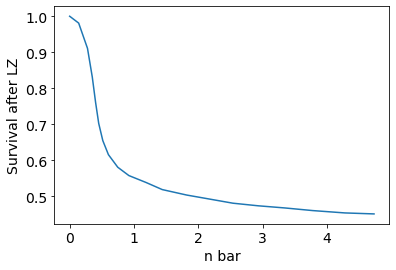

In [47]:
plt.plot(n_bars, 1-0.8*(1-survivals))
plt.xlabel("n bar", fontsize=14)
plt.ylabel("Survival after LZ", fontsize=14)
plt.tick_params(labelsize=14)